# Welcome to GPyEm!

GPyEm is a package used to create independent multi-output emulators for cohort emulation studies using GPyTorch.

In this tutorial we will go through the basics of generating emulators in GPyEm. 

# Installing GPyEm
## If you just want to use it...
```
pip install git+https://github.com/cwlanyon/GPyEm.git
```

## If you want to develop it...

Go to where you want to save your repo:
```
git clone https://github.com/cwlanyon/GPyEm.git
pip install -e GPyEm
```
So you can now import this in a python script anywhere you happen to be (no need to worry about paths etc):
```
from GPyEm import GPE_ensemble as GPE
```

## If you already have the repo on your computer...

Go to the location. E.g.
```
cd /home/me/Documents/code/GPyEm
```
Then call:
```
pip install -e .
```


In [1]:
# Import useful libraries
import math 
import torch 
import gpytorch # 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pyDOE import *


# Import GPyEm
from GPyEm import GPE_ensemble as GPE 

# Example 1: 1D input, 1D output

Creating an emulator for the function $$f(\theta)=\frac{\sin(2\theta)}{\theta}$$

Our observational model is $$y_i=f(\theta_i)+\epsilon_i$$ where $$\epsilon_i \sim N(0,\sigma^2$$.

We create a gaussian process emulator such that $$g(\theta)\approx f(\theta)$$

### Set up problem and generate observations for toy model

In [6]:
# Set observation upper and lower bounds
lb= 0.1 # lower bound
ub = 10 # upper bound

p = 100 # Number of observations (more means better emulation)

theta1 = torch.linspace(lb,ub,p) # Generate theta={theta_i}

q=10
theta2 = torch.linspace(lb,ub/2,q) # Generate theta={theta_i}
theta2=torch.tensor([0.1,1,2,3,4,8])

In [7]:
def oneD_func(theta): # define f(theta)
    return torch.sin(1*theta)/theta 

### Split data into training and testing 

In [9]:
# When training the emulator we need both inputs and outputs to have a 2 dimension shape attribute
# I.e. theta.shape = [p,1], rather than theta.shape = [p,], so we use [:,None] to generate that second dimension


X=theta1[:,None]
y=oneD_func(theta1)[:,None]

# Use train_test_split to split into training and desting data
theta_train, theta_test, y_train, y_test = train_test_split(
    X, #inputs
    y, #outputs
    test_size=0.2, # proportion (or integer valued) of total data set used for testing
)

### Train emulator

The basic setting for GPyEm is to generate an emulator with an RBF kernel and a constant mean

In [10]:
emulator=GPE.ensemble(theta_train,y_train) # Train GPE with assigned kernel parameters

0


In [11]:
emulator=GPE.ensemble(theta_train,y_train,n_restarts=5,X_test=theta_test,y_test=y_test)

0
0
0
0
0
tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<CopySlices>)
tensor([0])


### Predict with the emulator

emulator.predict(theta) returns the mean GP prediction at $\theta$

In [12]:
emulator.predict(theta_test[0:3]) # Mean prediction at three points

tensor([[0.0472],
        [0.9585],
        [0.5412]], grad_fn=<PermuteBackward0>)

emulator.predict_sample(theta,n) provides samples from the predictive posterior n times at $\theta$

In [13]:
emulator.predict_sample(theta_test[0:3],n=5)

/Users/pmzcwl/Documents/GitHub/Calibration/GPyEm/GPE_ensemble.py:208: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  prediction=torch.stack(prediction).T


tensor([[[0.0471],
         [0.0534],
         [0.0509],
         [0.0423],
         [0.0480]],

        [[0.9584],
         [0.9616],
         [0.9620],
         [0.9564],
         [0.9572]],

        [[0.5487],
         [0.5399],
         [0.5402],
         [0.5437],
         [0.5373]]])

### Evaluating the emulator

GPyEm has three key built in metrics, the mean squared error (MSE), $R^2$ and the independent standard error (ISE).

These can be generated from the mean prediction:

In [14]:
emulator.MSE(theta_test,y_test)

tensor([3.4152e-08], grad_fn=<MeanBackward1>)

In [15]:
emulator.R2(theta_test,y_test)

tensor([1.0000], grad_fn=<RsubBackward1>)

In [16]:
emulator.ISE(theta_test,y_test)

tensor([100.])

The MSE and $R^2$ can also be generated sampling from the posterior, these functions return the mean score and the standard deviation amongst the samples:

In [17]:
emulator.MSE_sample(theta_test,y_test,n=100)

/Users/pmzcwl/Documents/GitHub/Calibration/GPyEm/GPE_ensemble.py:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_mean = torch.tensor(MSE_score.mean(axis=0))
/Users/pmzcwl/Documents/GitHub/Calibration/GPyEm/GPE_ensemble.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  MSE_std = torch.tensor(MSE_score.std(axis=0))


(tensor([1.2664e-05]), tensor([4.0143e-06]))

In [19]:
emulator.R2_sample(theta_test,y_test,n=100)

(tensor([0.9999]), tensor([2.4925e-05]))

### Predict with the emulator and plot

In [20]:
theta_ex = torch.linspace(lb,ub+10,50) # Prediction points outside of original training

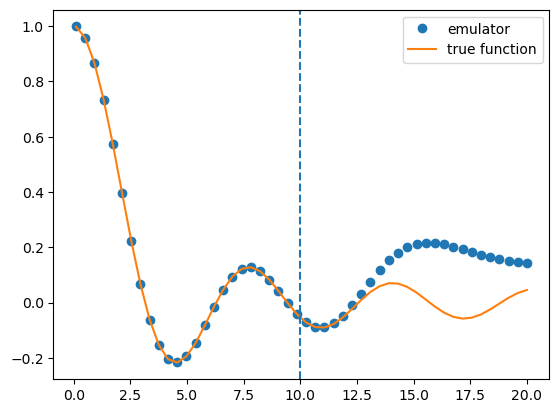

In [21]:
plt.plot(theta_ex,emulator.predict(theta_ex).detach().numpy(),'o') #plot emulator prediction
plt.plot(theta_ex,oneD_func(theta_ex)) # plot true function
plt.legend(['emulator','true function'])
plt.axvline(x=ub,linestyle='--') # dashed line at training upper bound

# Quick example regression figure:


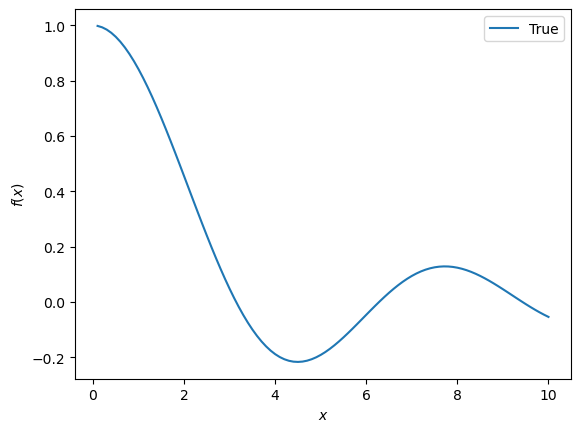

In [22]:
plt.plot(theta1,oneD_func(theta1)) # Plot f(\theta)
#plt.plot(theta2,oneD_func(theta2),'o') # Plot f(\theta)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(['True'])
plt.savefig('trueFunc')

In [23]:
noisy = oneD_func(theta2)+torch.tensor(np.random.normal(0,0.02,len(theta2)))

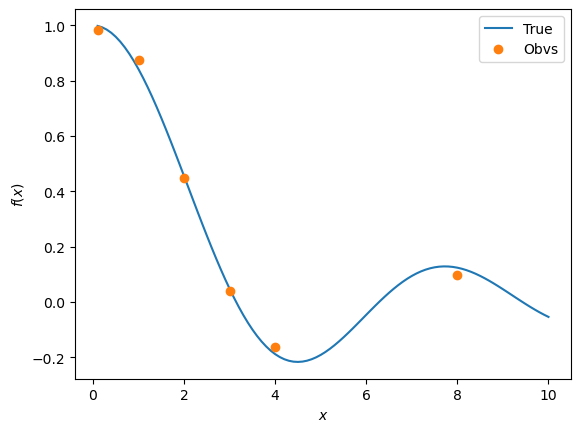

In [24]:
plt.plot(theta1,oneD_func(theta1)) # Plot f(\theta)
plt.plot(theta2,noisy,'o') # Plot f(\theta)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend(['True','Obvs'])
plt.savefig('trueFuncObvs')

In [25]:
emulator=GPE.ensemble(theta2[:,None],noisy[:,None],training_iter=1000)

0


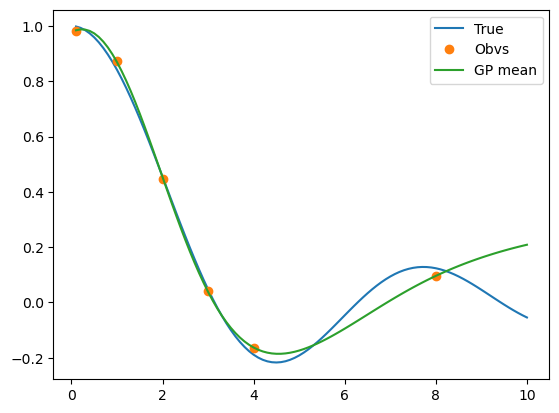

In [26]:
plt.plot(theta1,oneD_func(theta1)) # Plot f(\theta)
plt.plot(theta2,noisy,'o') # Plot f(\theta)
plt.plot(theta1,emulator.predict(theta1).detach().numpy())
plt.legend(['True','Obvs','GP mean'])
plt.savefig('GPMean')

In [27]:
theta1 = torch.linspace(lb,ub,50) # Generate theta={theta_i}

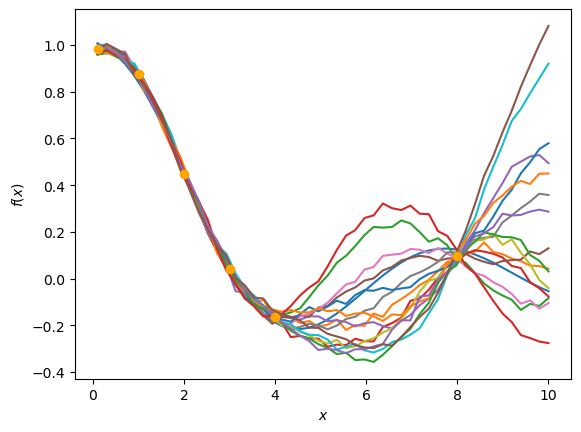

In [28]:
plt.plot(theta1,oneD_func(theta1)) # Plot f(\theta)
plt.plot(theta1,emulator.predict_sample(theta1,15).squeeze().detach().numpy()) # Plot f(\theta)
plt.plot(theta2,noisy,'o',color='orange') # Plot f(\theta)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.savefig('GPSample')

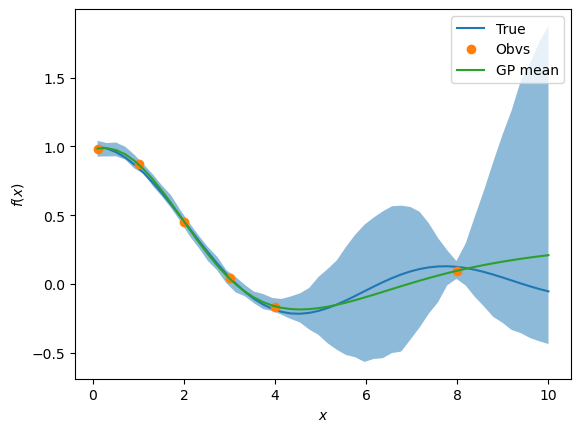

In [29]:
upper=emulator.predict_sample(theta1,100).squeeze().detach().numpy().mean(axis=1)+3*emulator.predict_sample(theta1,15).squeeze().detach().numpy().std(axis=1)
lower=emulator.predict_sample(theta1,100).squeeze().detach().numpy().mean(axis=1)-3*emulator.predict_sample(theta1,15).squeeze().detach().numpy().std(axis=1)
plt.plot(theta1,oneD_func(theta1)) # Plot f(\theta)
plt.plot(theta2,noisy,'o') # Plot f(\theta)
plt.plot(theta1,emulator.predict(theta1).detach().numpy())
plt.legend(['True','Obvs','GP mean'])
plt.fill_between(theta1,upper,lower,alpha=0.5)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.savefig('GPSample')
plt.savefig('GPuncertainty')

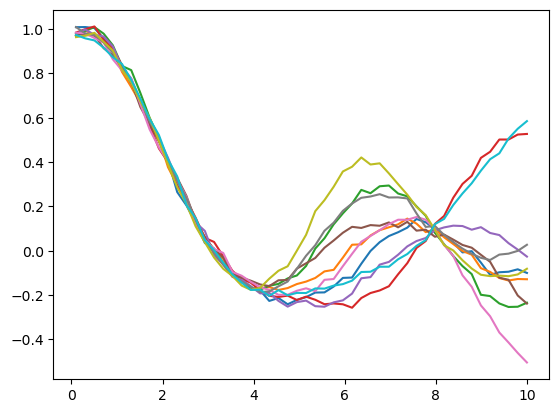

In [30]:
plt.plot(theta1,emulator.predict_sample(theta1,10).detach().numpy().squeeze())

# Example 2: 1D input, 2D output

Creating an emulator for the function 

$ f(\theta)=\begin{cases}
f_1(\theta)=\frac{\sin(2\theta)}{\theta} \\
f_2(\theta)=\theta
\end{cases}
$

Our observational model is $$y_i=f(\theta_i)+\epsilon_i$$ where $$\epsilon_i \sim N(0,\sigma^2$$

We create a gaussian process emulator such that $$g(\theta)\approx f(\theta)$$

### Set up problem and generate observations for toy model

In [31]:
lb= 0.1 # lower bound
ub = 10 # upper bounds
p = 30  # observations (more means better emulation)

theta = torch.linspace(lb,ub,p)

In [32]:
def twoD_func(theta): # define f
    out=torch.stack([torch.sin(2*theta)/theta,theta],axis=1)
    return out

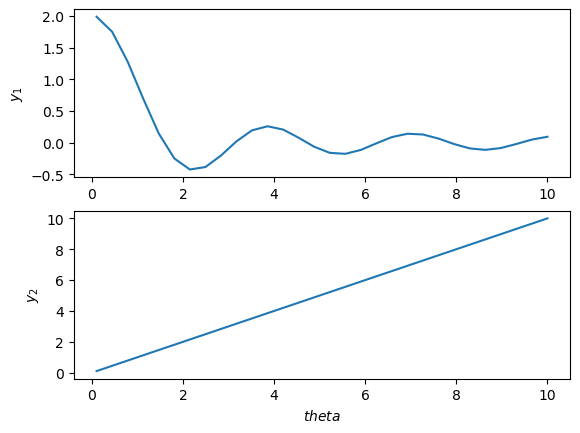

In [33]:
fig, axs = plt.subplots(2) # plot f
axs[0].plot(theta,twoD_func(theta)[:,0])
axs[1].plot(theta,twoD_func(theta)[:,1])
axs[0].set(ylabel='$y_1$');
axs[1].set(xlabel='$theta$', ylabel='$y_2$');

### Train emulator

In [34]:
X=theta[:,None]
y=twoD_func(theta)+torch.normal(mean=0., std=0.01,size=[p,2]) # we no longer need the [:,None] as y is already 2D
theta_train, theta_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [35]:
emulator=GPE.ensemble(theta_train,y_train,mean_func='linear') 

0
1


In [36]:
emulator.R2(theta_test,y_test)

tensor([0.9947, 1.0000], grad_fn=<RsubBackward1>)

In [37]:
emulator=GPE.ensemble(theta_train,y_train,n_restarts=5,X_test=theta_test,y_test=y_test,mean_func='linear') 

0
1
0
1
0
1
0
1
0
1
tensor([[0.9947, 1.0000],
        [0.9947, 1.0000],
        [0.9947, 1.0000],
        [0.9947, 1.0000],
        [0.9947, 1.0000]], grad_fn=<CopySlices>)
tensor([1, 0])


In [38]:
emulator.R2(theta_test,y_test)

tensor([0.9947, 1.0000], grad_fn=<RsubBackward1>)

### Evaluate and plot emulator outside of training bounds

In [39]:
theta_ex = torch.linspace(lb,ub+10,50)

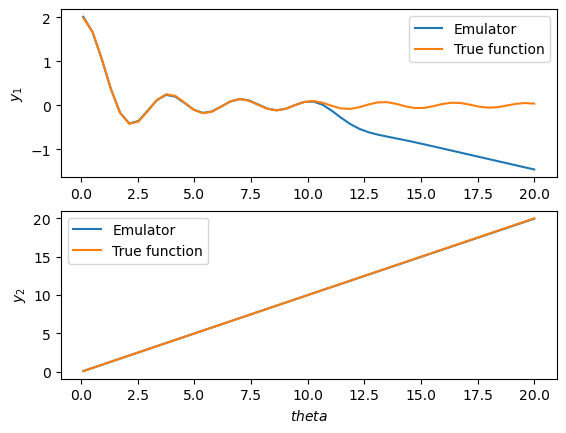

In [40]:
fig, axs = plt.subplots(2)
axs[0].plot(theta_ex,emulator.predict(theta_ex)[:,0].detach().numpy())
axs[0].plot(theta_ex,twoD_func(theta_ex)[:,0])
axs[1].plot(theta_ex,emulator.predict(theta_ex)[:,1].detach().numpy())
axs[1].plot(theta_ex,twoD_func(theta_ex)[:,1])
axs[0].set(ylabel='$y_1$');
axs[1].set(xlabel='$theta$', ylabel='$y_2$');
axs[0].legend(['Emulator','True function'])
axs[1].legend(['Emulator','True function'])

# Example 3: 2D input, 1D output

Here we emulate the Branin function:
$$f(\theta) = a(\theta_2-b\theta_1^2+c\theta_1-r)^2+s(1-t)\cos(\theta_1)+s$$

With $a=1$, $b=5.1/(4*\pi**2)$, $c=5/\pi$, $r=6$, $s=10$, $t=1/(8*\pi)$.

In [41]:
def branin(xx, a=1, b=5.1/(4.0*np.pi**2), c=5.0/np.pi, r=6.0, s=10.0, t=1.0/(8.0*np.pi)): #Branin Function
    x1 = xx[0]
    x2 = xx[1]
    term1 = a * (x2 - b*x1**2 + c*x1 - r)**2
    term2 = s*(1-t)*np.cos(x1)
    y = term1 + term2 + s
    return(y)

In [42]:
rl = [-5,0] #lower observational bound
ru=[10,15] #upper observational bound

tp = 500 # number of plotting points

p = 30 # number of training points (more means better emulation)

#x_test = torch.linspace(ru,rl,tp) #test points over full range

In [43]:
#Define meshgrid over domain

X=np.linspace(rl[0],ru[0],100) 
Y=np.linspace(rl[1],ru[1],100)
XX,YY=np.meshgrid(X,Y)
Z=branin(np.array([XX,YY])) #Evaluate Branin on domain

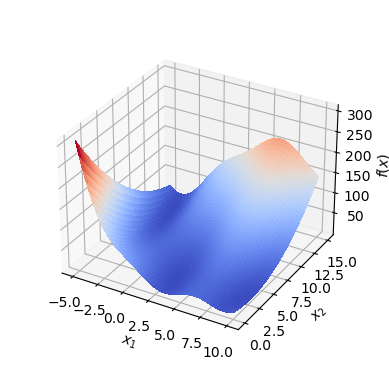

In [44]:
#3D Plot of the Branin function

from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')
ax.set_box_aspect(None, zoom=0.85)
# Plot the surface.
surf = ax.plot_surface(XX, YY, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### Train emulator

In [45]:
# maximin sampling from a latin hypercube

theta=torch.tensor(lhs(2,p,criterion='maximin')*(np.array(ru)-np.array(rl))+np.array(rl)) 
 

In [46]:
y=(branin(theta.T))

In [47]:
X=theta
y=(branin(theta.T)+torch.normal(mean=0., std=0.01,size=[p]))[:,None]
theta_train, theta_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
)

In [48]:
emulator=GPE.ensemble(theta_train,y_train) 

0


In [49]:
emulator=GPE.ensemble(theta_train,y_train,n_restarts=5,X_test=theta_test,y_test=y_test,mean_func='linear') 

0
0
0
0
0
tensor([[0.9858],
        [0.9857],
        [0.9857],
        [0.9857],
        [0.9857]], grad_fn=<CopySlices>)
tensor([0])


### Evaluate emulator

In [50]:
emulator.R2(theta_test,y_test)

tensor([0.9858], dtype=torch.float64, grad_fn=<RsubBackward1>)

In [51]:
candidateInput=torch.tensor(np.stack((XX,YY), axis=-1).reshape(10000,2))


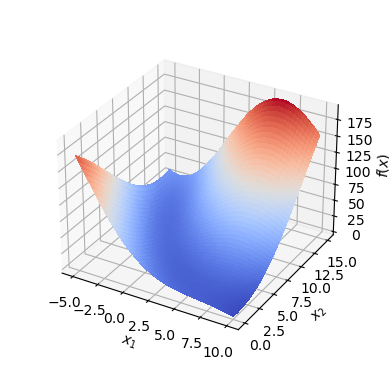

In [52]:
#3D Plot of the Branin function

from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')
ax.set_box_aspect(None, zoom=0.85)
# Plot the surface.
surf = ax.plot_surface(XX, YY, emulator.predict(candidateInput).reshape(100,100).detach().numpy(), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False) 

### Comparison between emulator and true function

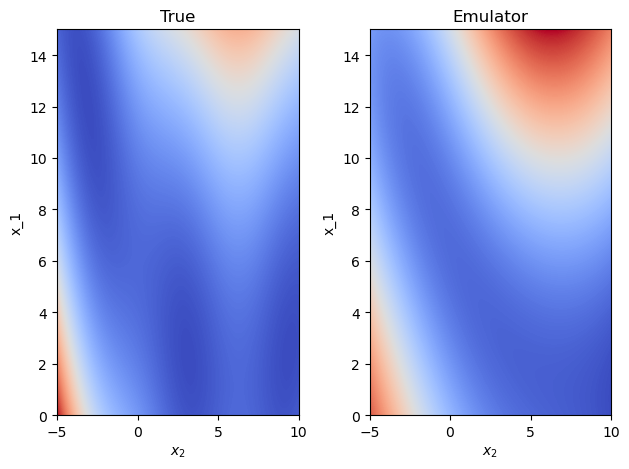

In [53]:
fig, axs = plt.subplots(1,2)
axs[0].contourf(XX,YY,Z,origin='lower',levels=500,cmap=cm.coolwarm)
axs[1].contourf(XX,YY, emulator.predict(candidateInput).reshape(100,100).detach().numpy(),origin='lower',levels=500,cmap=cm.coolwarm)
axs[0].set(ylabel='x_1',xlabel='$x_2$',title='True');
axs[1].set(ylabel='x_1',xlabel='$x_2$',title='Emulator');
fig.tight_layout()